# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

In [3]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [4]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [5]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,mark-mac,turing-minimacbook,traverses-mac,theatergoing-mac,turing-macbook,turing-chromebook,languid-mac,LAPTOP-1I501C4U,misskitty-mac,tirasse-mac,...,boundless-mac,essential-cb,MalcomWare-PC,nervings-cb,simon-macpro,abroad-android,dramatic-mac,appropriate-android,calcannea-cb,score
sc-static.net,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
jifo.co,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
qkme.me,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
costargroup.com,0,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,11
csptcs.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
media-amazon.com,0,0,0,1,0,0,4,0,8,0,...,1,2,0,11,0,0,0,0,0,47
escapetv.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
nedbatchelder.com,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
fivetran.com,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,3
wikiversity.org,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,3


## Get list of highest accessed domains by all devices

In [6]:
n = 100
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com', 'in-addr.arpa', 'clubhouse.io', 'akadns.net',
       'doubleclick.net', 'netgear.com', 'slack.com', 'amazonaws.com',
       'googleusercontent.com', 'github.com', 'facebook.com',
       'akamaiedge.net', 'google.co.uk', 'icloud.com', 'microsoft.com',
       'apple-dns.net', 'virustotal.com', 'amazon.com', 'rbxcdn.com',
       'cloudapp.net', 'utun1.viscosity', 'codeanywhere.com',
       'utun2.viscosity', 'cloudfront.net', 'google-analytics.com',
       'adnxs.com', 'bbc.co.uk', 'ea.com', 'adsafeprotected.com',
       'skype.com', 'slack-edge.com', 'githubusercontent.com',
       'linkedin.com', 'googlesyndication.com', 'intercom.io',
       'hubspot.com', 'slack-msgs.com', 'fastly.net', 'ddns.net',
       'bbci.co.uk', 'trafficmanager.net', 'pubmatic.com',
       'doubleverify.com', 'gravatar.com', 'azureedge.net', 'twitter.com',
       'imrworldwide.com', 'gvt2.com', 'quantserve.com', 'orig

## Spearman's Rho

In [7]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

In [8]:
spearman(["b", "a", "x"], ["a", "c", "x"])

-1.5

In [9]:
spearman(["a", "c", "x"], ["b", "a", "x"])

-1.5

## Get favourite domains by device

In [10]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['mark-mac',
  array(['facebook.com', 'virustotal.com', 'google.com', 'twisted.ru',
         'bbc.co.uk', 'trustnetworks.com', 'gstatic.com',
         'fedoraproject.org', 'apple.com', 'clubhouse.io', 'in-addr.arpa',
         'bbci.co.uk', 'googleapis.com', 'apility.net', 'doubleclick.net',
         'slack.com', 'google.co.uk', 'googleusercontent.com', 'icloud.com',
         'github.com', 'intercom.io', 'connatix.com', 'voipfone.net',
         'githubusercontent.com', 'google-analytics.com', 'googlevideo.com',
         'doubleverify.com', 'googlesyndication.com', 'slack-edge.com',
         'cloudfront.net', 'apple-dns.net', 'scorecardresearch.com',
         'dynatrace.com', 'twitter.com', 'adnxs.com', 'youtube.com',
         'amazonaws.com', 'amazon.com', 'chartbeat.net', 'ytimg.com',
         'adsafeprotected.com', 'nationalrail.co.uk', 'contextweb.com',
         'bbc.com', 'rubiconproject.com', 'slashdot.org', 'consensu.org',
         'advertising.com', 'tunnelblick.net', 'fbcdn.net

In [11]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
mark-mac,"[facebook.com, virustotal.com, google.com, twi..."
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar..."
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n..."
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,..."
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n..."
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac..."
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic...."
LAPTOP-1I501C4U,"[microsoft.com, trustnetworks.com, mcafee.com,..."
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat..."


## Compute Spearman co-efficient
against most common domains

In [12]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [13]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
minesweepers-mac,"[google.com, github.com, in-addr.arpa, apple.c...",-1.03
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.24
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.25
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",-1.53
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",-1.87
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.98
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-2.02
nervings-cb,"[google.com, clubhouse.io, googleapis.com, gst...",-2.11
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-2.15


## Device to device co-efficient

In [14]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]

In [15]:
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")

In [16]:
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x))

In [17]:
df3

,domains,mark-mac,turing-minimacbook,traverses-mac,theatergoing-mac,turing-macbook,turing-chromebook,languid-mac,LAPTOP-1I501C4U,misskitty-mac,...,essential-chrome,boundless-mac,essential-cb,MalcomWare-PC,nervings-cb,simon-macpro,abroad-android,dramatic-mac,appropriate-android,calcannea-cb
device,,,,,,,,,,,,,,,,,,,,,
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",1.000000,-2.947117,-4.023222,-2.143228,-3.472829,-2.886823,-2.434635,-2.755242,-2.314707,...,-2.457282,-1.903144,-2.329091,-3.306145,-2.317966,-2.993189,-2.757456,-2.597570,-2.921332,-2.360672
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",-2.947117,1.000000,-3.327591,-3.048281,-2.376832,-1.650699,-2.547999,-3.412637,-2.384422,...,-2.750033,-2.724188,-2.272373,-3.946361,-3.340132,-1.173789,-3.585971,-2.864854,-3.531965,-3.415782
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",-4.023222,-3.327591,1.000000,-4.038272,-2.377984,-3.745191,-3.709481,-4.440306,-3.821902,...,-4.310057,-3.715818,-4.094971,-4.524926,-4.367693,-3.205317,-4.407597,-3.546487,-4.434965,-4.334203
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,...",-2.143228,-3.048281,-4.038272,1.000000,-3.412925,-2.909919,-3.085377,-2.712907,-2.109499,...,-2.790765,-2.002748,-2.553609,-3.935638,-2.577186,-3.102232,-3.620066,-3.415812,-3.171725,-2.725455
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",-3.472829,-2.376832,-2.377984,-3.412925,1.000000,-2.417996,-3.470531,-4.132127,-3.012625,...,-3.619256,-3.561026,-3.621950,-4.483420,-3.789391,-2.505581,-4.152649,-3.636124,-3.957792,-3.883234
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",-2.886823,-1.650699,-3.745191,-2.909919,-2.417996,1.000000,-2.918596,-3.540924,-2.611545,...,-2.336274,-3.075968,-2.368293,-4.052541,-3.315020,-1.436196,-3.413699,-3.157288,-3.506001,-3.304452
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-2.434635,-2.547999,-3.709481,-3.085377,-3.470531,-2.918596,1.000000,-3.407843,-2.171833,...,-3.140882,-2.093609,-2.936712,-3.633843,-3.029373,-2.774383,-3.064446,-2.946991,-3.420480,-2.940618
LAPTOP-1I501C4U,"[microsoft.com, trustnetworks.com, mcafee.com,...",-2.755242,-3.412637,-4.440306,-2.712907,-4.132127,-3.540924,-3.407843,1.000000,-2.925767,...,-2.584848,-2.596886,-2.691419,-2.865761,-2.230987,-3.609391,-3.215326,-3.185053,-3.123684,-2.806445
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-2.314707,-2.384422,-3.821902,-2.109499,-3.012625,-2.611545,-2.171833,-2.925767,1.000000,...,-2.836298,-1.545911,-2.558812,-3.667981,-2.671965,-2.744404,-3.463918,-2.985143,-3.174803,-2.651047


In [18]:
## Calculate log10(coefficient)
my_fn = lambda x: np.log10(x + 10)
df4 = df3.copy()
df4[all_devices] = df4[all_devices].apply(lambda x: [my_fn(v) for v in x])

In [19]:
df4

,domains,mark-mac,turing-minimacbook,traverses-mac,theatergoing-mac,turing-macbook,turing-chromebook,languid-mac,LAPTOP-1I501C4U,misskitty-mac,...,essential-chrome,boundless-mac,essential-cb,MalcomWare-PC,nervings-cb,simon-macpro,abroad-android,dramatic-mac,appropriate-android,calcannea-cb
device,,,,,,,,,,,,,,,,,,,,,
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",1.041393,0.848367,0.776467,0.895244,0.814725,0.852064,0.878830,0.860024,0.885660,...,0.877528,0.908316,0.884847,0.825676,0.885476,0.845520,0.859891,0.869374,0.849952,0.883055
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",0.848367,1.041393,0.824283,0.842092,0.882136,0.921650,0.872273,0.818712,0.881703,...,0.860336,0.861881,0.888046,0.782017,0.823466,0.945774,0.807131,0.853403,0.810772,0.818504
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.776467,0.824283,1.041393,0.775372,0.882070,0.796214,0.798686,0.745051,0.790855,...,0.755108,0.798249,0.771222,0.738390,0.750686,0.832169,0.747598,0.809796,0.745468,0.753261
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,...",0.895244,0.842092,0.775372,1.041393,0.818693,0.850651,0.839769,0.862554,0.897105,...,0.857889,0.902941,0.871946,0.782785,0.870569,0.838709,0.804816,0.818502,0.834311,0.861806
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.814725,0.882136,0.882070,0.818693,1.041393,0.879784,0.814878,0.768481,0.844314,...,0.804871,0.808817,0.804688,0.741670,0.793134,0.874738,0.766959,0.803722,0.781196,0.786522
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",0.852064,0.921650,0.796214,0.850651,0.879784,1.041393,0.850119,0.810170,0.868554,...,0.884440,0.840359,0.882622,0.774331,0.825100,0.932667,0.818642,0.835228,0.812512,0.825786
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",0.878830,0.872273,0.798686,0.839769,0.814878,0.850119,1.041393,0.819028,0.893660,...,0.836268,0.897978,0.849007,0.803877,0.843272,0.858875,0.841081,0.848374,0.818194,0.848767
LAPTOP-1I501C4U,"[microsoft.com, trustnetworks.com, mcafee.com,...",0.860024,0.818712,0.745051,0.862554,0.768481,0.810170,0.819028,1.041393,0.849679,...,0.870120,0.869414,0.863833,0.853348,0.890366,0.805542,0.831529,0.833463,0.837356,0.856944
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",0.885660,0.881703,0.790855,0.897105,0.844314,0.868554,0.893660,0.849679,1.041393,...,0.855138,0.927067,0.871642,0.801542,0.864988,0.860673,0.815317,0.846019,0.834115,0.866225


## Plot it, heatmap

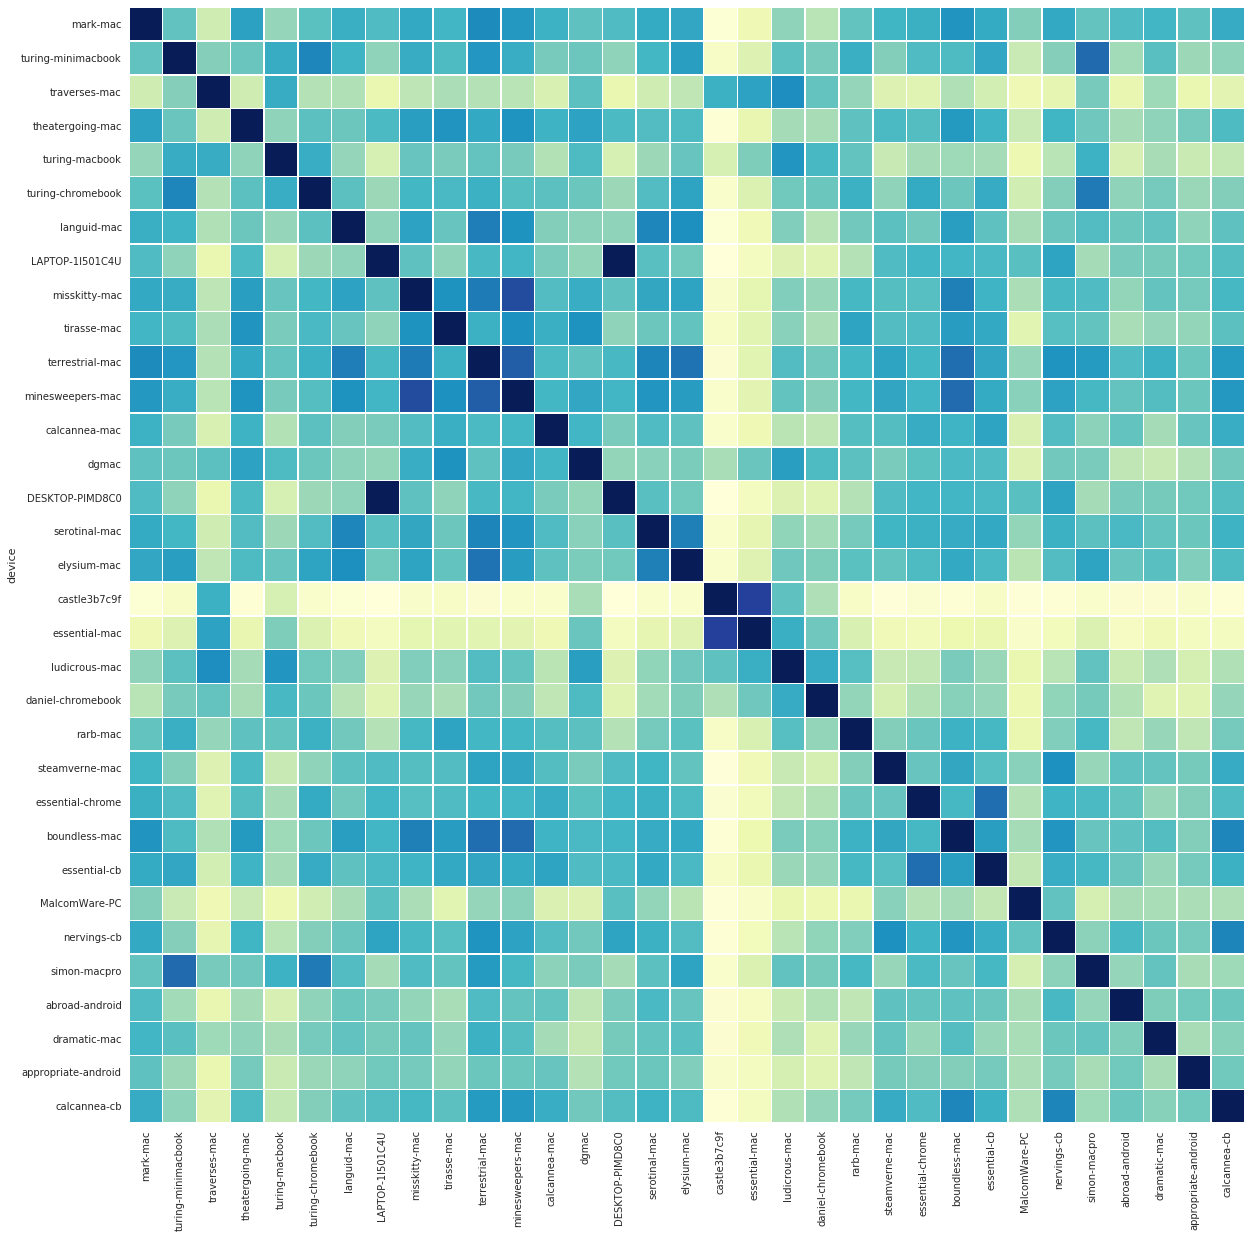

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df4[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()